# Question 1
---

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [8]:
bcancer = pd.read_csv('breast-cancer.csv')
print(bcancer.head())
print(bcancer.isnull().sum())
bcancer_predictors = [
 "radius_mean",
 "perimeter_mean",
 "area_mean",
 "compactness_mean",
 "concavity_mean",
 "concave points_mean",
 "radius_worst",
 "perimeter_worst",
 "area_worst",
 "concavity_worst"
]
bcancer["diagnosis_binary"] = (bcancer["diagnosis"] == "M").astype(int)
X = bcancer[bcancer_predictors].values  # shape: (n_samples, p)
y = bcancer["diagnosis_binary"].values  # shape: (n_samples,)

# Make the Norma(0,1) priors on beta more interpretable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [9]:
with pm.Model() as logistic_model:
    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)  # intercept
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X_scaled.shape[1])

    # Linear predictor
    mu = alpha + pm.math.dot(X_scaled, betas)
    
    # Bernoulli likelihood with logit link
    y_obs = pm.Bernoulli("y_obs", logit_p=mu, observed=y)

    # MCMC sampling
    bcancer_sim = pm.sample(
        draws = 5000,      
        tune = 1000,       
        chains = 4 
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 12 seconds.
There were 6953 divergences after tuning. Increase `target_accept` or reparameterize.


In [10]:
az.summary(bcancer_sim, var_names=["alpha", "betas"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.321,0.242,-0.779,0.134,0.003,0.002,7707.254,4861.117,1.001
betas[0],-0.630,0.840,-2.250,0.925,0.008,0.007,11334.763,8201.437,1.000
betas[1],-0.573,0.843,-2.187,0.981,0.008,0.007,11531.273,8362.960,1.000
betas[2],-0.299,0.848,-1.863,1.309,0.008,0.007,11298.839,9204.677,1.001
betas[3],-0.500,0.415,-1.269,0.284,0.004,0.003,11658.988,11107.073,1.000
betas[4],-0.156,0.517,-1.118,0.835,0.006,0.004,8799.833,8959.694,1.000
betas[5],2.316,0.609,1.193,3.495,0.006,0.004,9929.737,9453.244,1.000
betas[6],2.154,0.843,0.556,3.697,0.008,0.006,10448.772,7597.439,1.000
betas[7],1.631,0.843,0.029,3.188,0.008,0.006,11168.614,10645.889,1.001
betas[8],2.032,0.844,0.419,3.574,0.009,0.007,8464.995,6005.340,1.000


From the table, we see that compactness_mean, concavity_mean, concave points_mean, perimeter_worst, area_worst, and concavity_worst strongly increase the log-odds of a tumor being malignant because their 94% HDIs are fully above 0. The other predictors are uncertain because their intervals intersect 0.

The ESS are on the low side, being around half of the simulation size of 20000. However, r_hat is 1 so we still have convergence.

Overall, the model suggests that more complex/irregular tumor shapes are strongly associated with a higher probability of malignancy.

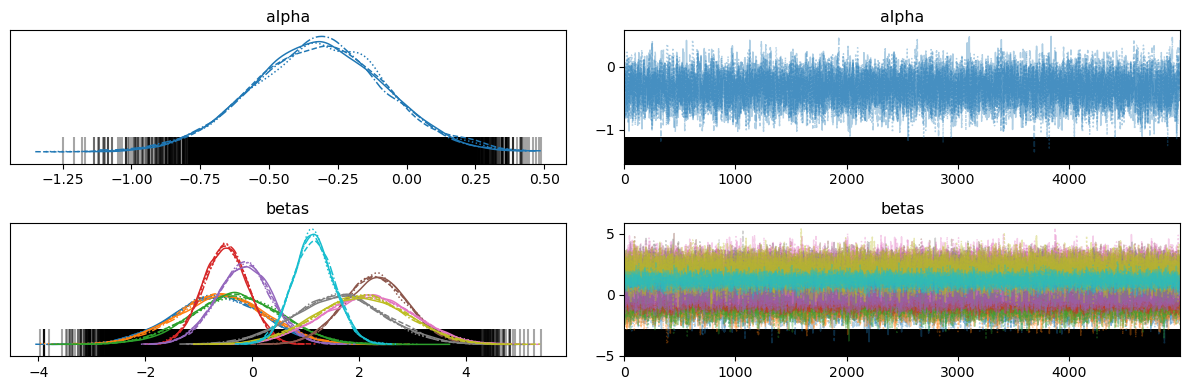

In [16]:
az.plot_trace(bcancer_sim, var_names=["alpha", "betas"])
plt.tight_layout()
plt.show()

Alpha: 

The density is centered around approximately −0.3, which matches the summary table. The trace looks stable with no major trends—suggesting good mixing.

Betas:

The left density plots show each beta’s approximate distribution. Some are clearly centered above zero; others overlap zero.
The right panel shows that each chain moves around without drifting or sticking, again indicating decent mixing and convergence.

Rug Plots:

The black ticks show that the samples are well spread out around each distribution’s mode. No empty gaps can be seen, which also hints at good mixing.

/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:272: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (44) in plot_autocorr, generating only 40 plots
  warnings.warn(


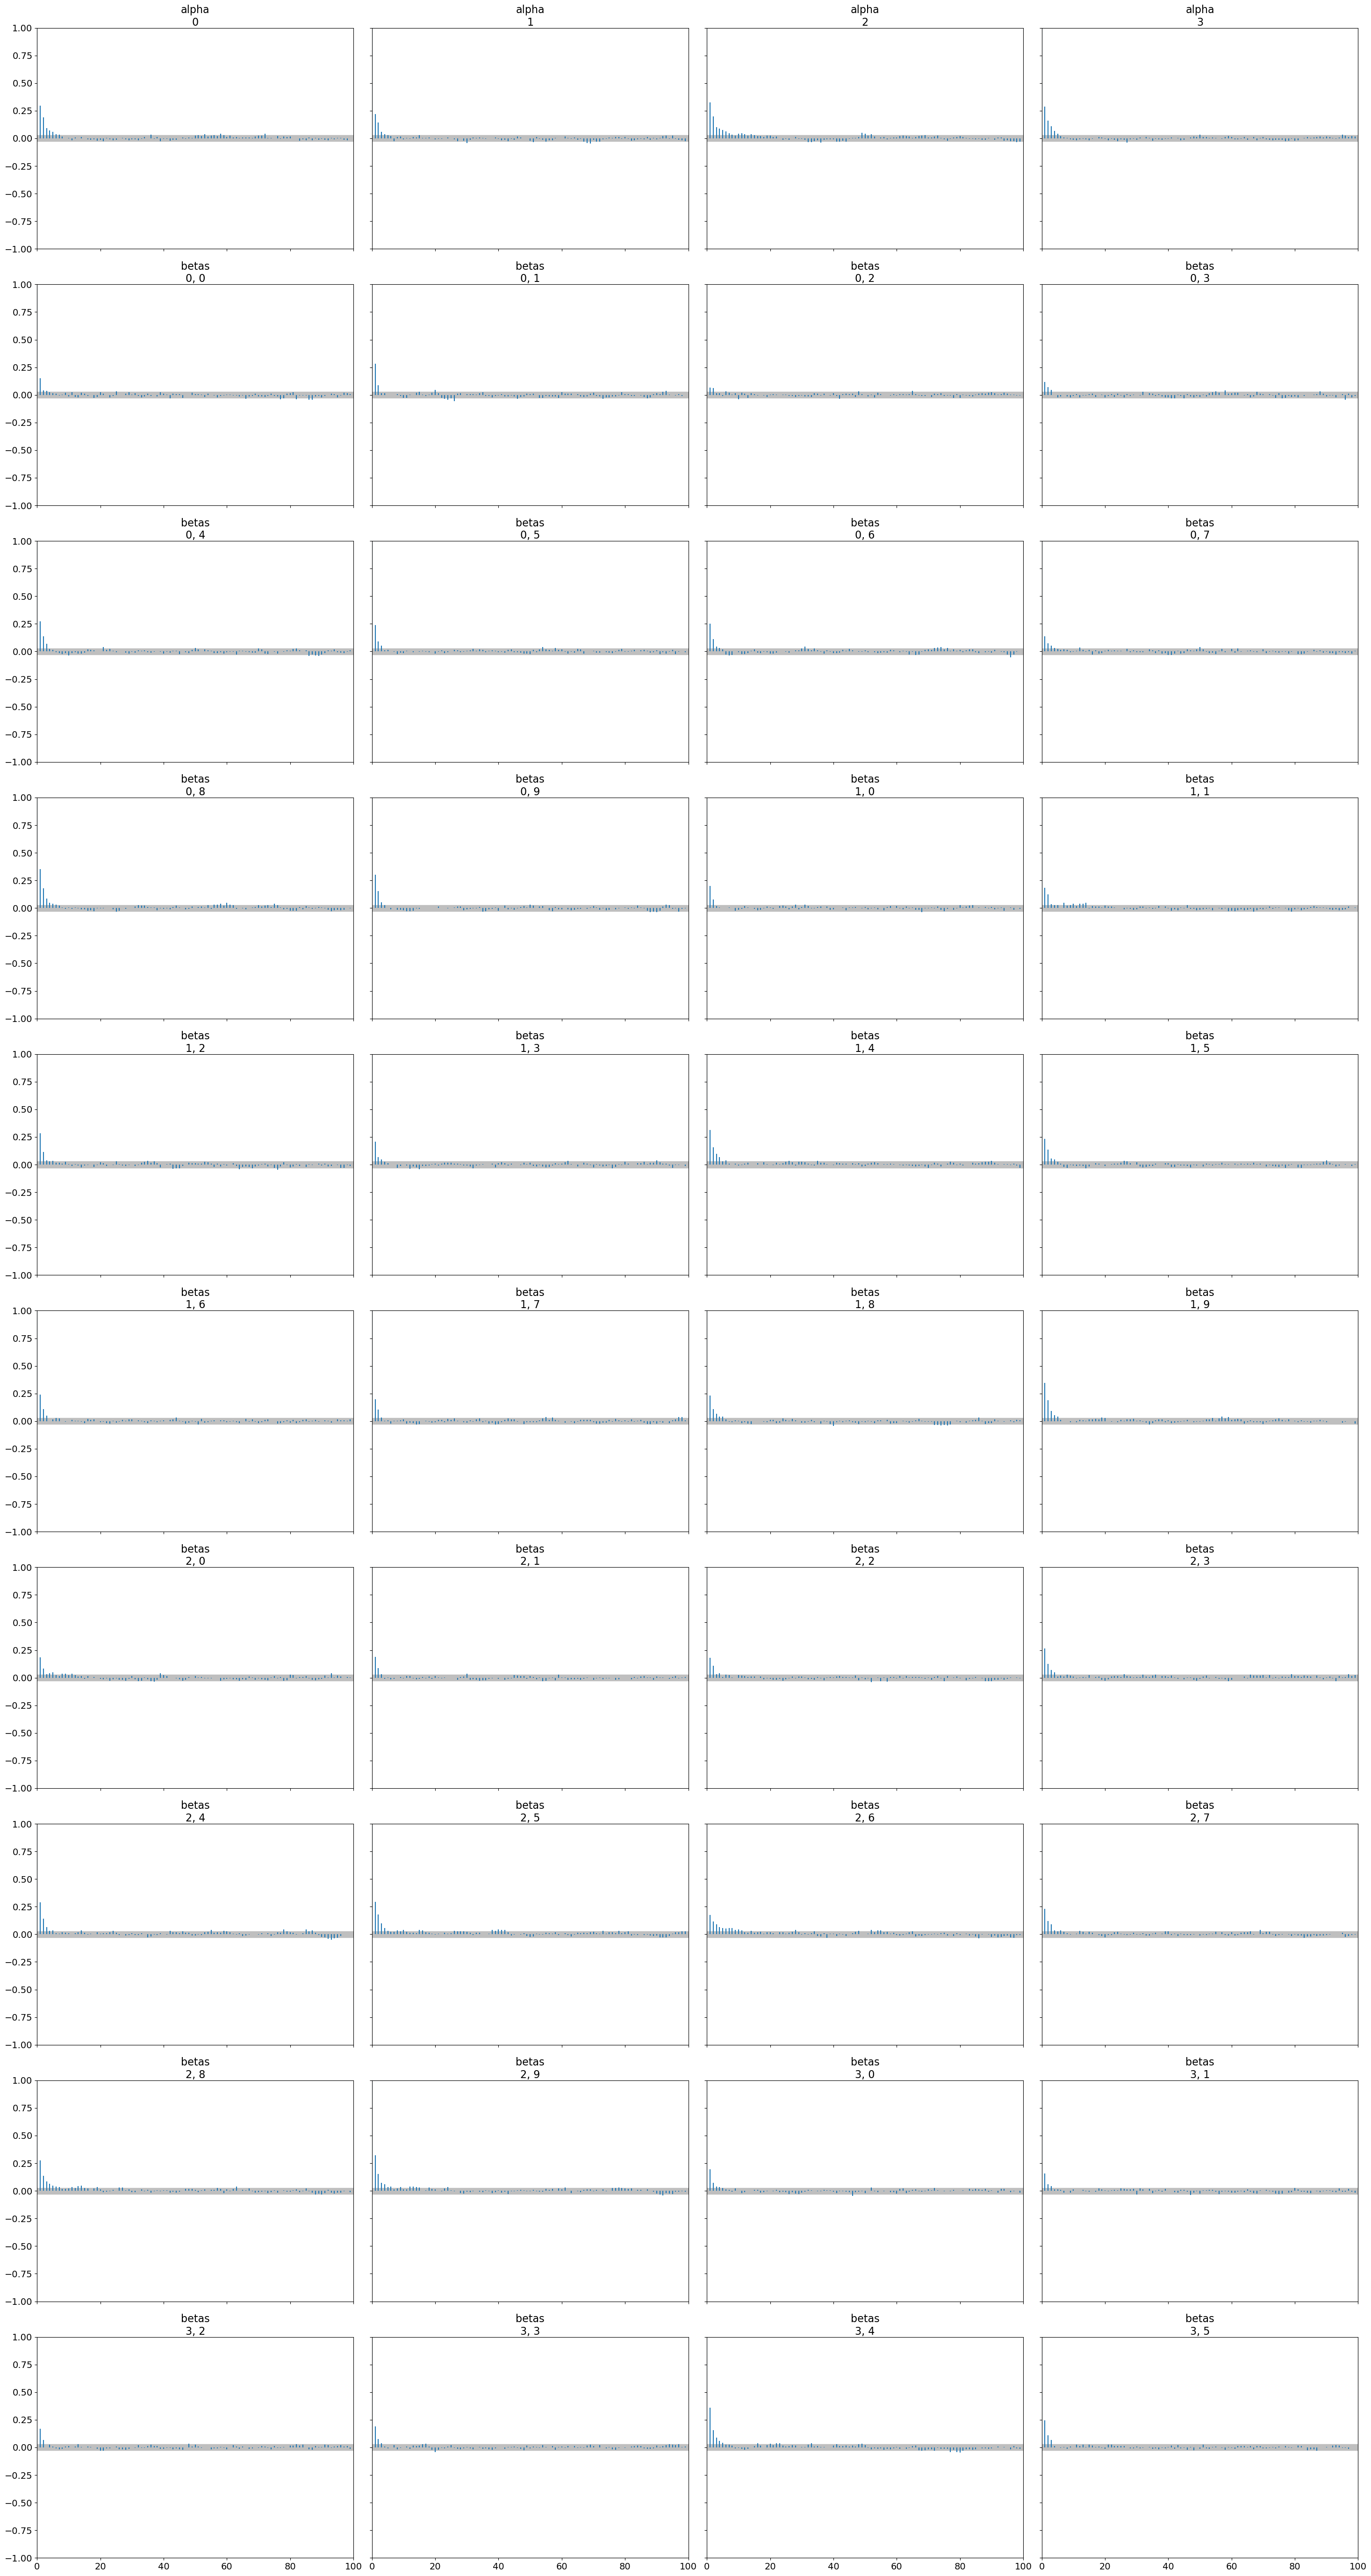

In [17]:
az.plot_autocorr(bcancer_sim, var_names=["alpha", "betas"])
plt.tight_layout()
plt.show()

Each parameter’s autocorrelation quickly settles near zero for lags > 0. This indicates good mixing—the chain’s successive samples aren’t sticking together or slowly drifting.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

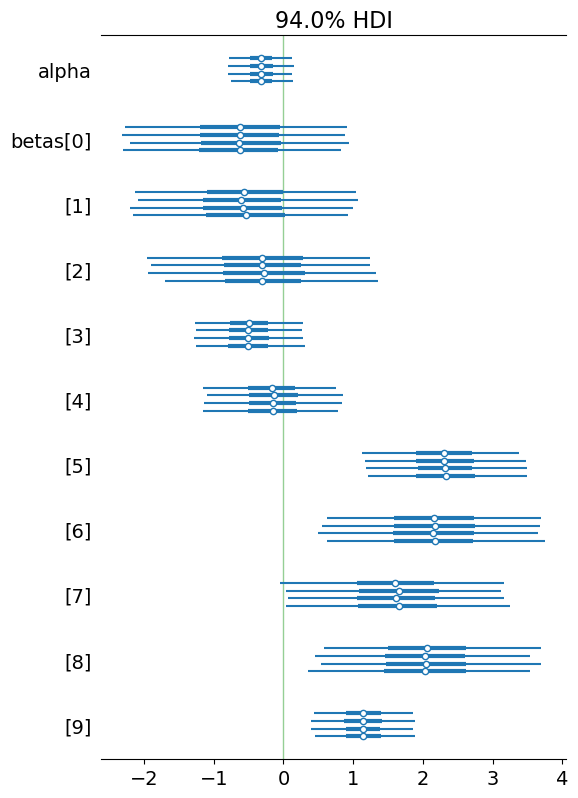

In [27]:
az.plot_forest(bcancer_sim, var_names=["alpha", "betas"], rope = (0,0))

This shows the HDI information from az.summary but in an easier-to-see format. We also see that all four chains produce very similar results.

# Question 2
---

In [8]:
wine = pd.read_csv('Wine dataset.csv')
print(wine.head())
print(wine.isnull().sum())

predictors = ["class", "Alcohol", "Color intensity", "Hue"]
X = wine[predictors].values  # shape: (n, p)

# Our outcomes (two columns)
Y = wine[["Magnesium", "Flavanoids"]].values  # shape: (n, 2)

n, p = X.shape
m = Y.shape[1]  # m=2 outcomes


   class  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0      1    14.23        1.71  2.43               15.6        127   
1      1    13.20        1.78  2.14               11.2        100   
2      1    13.16        2.36  2.67               18.6        101   
3      1    14.37        1.95  2.50               16.8        113   
4      1    13.24        2.59  2.87               21.0        118   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color intensity   Hue  OD280/OD315 of diluted wines  Proline   
0             5.64  1.04                          3.92      1065  
1             4.38  1.05

In [19]:
with pm.Model() as MVN_LKJ:
    # LKJCholeskyCov factorizes the covariance
    packed_L = pm.LKJCholeskyCov(
        'packed_L',
        n=m,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0, shape=m),
        compute_corr=False
    )
    # L is the lower-triangular Cholesky factor
    L = pm.expand_packed_triangular(m, packed_L)
    
    # Covariance = L * L^T
    Sigma = pm.Deterministic('Sigma', L @ L.T)

    # Regression coefficients (p x m)
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))

    # Linear predictor
    mu = pm.math.dot(X, betas)

    # Multivariate Normal likelihood, using the Cholesky factor
    Y_obs = pm.MvNormal('Y_obs', mu=mu, chol=L, observed=Y)
    
    # Simulate
    wine_sim = pm.sample(
        draws = 5000, 
        tune = 1000, 
        random_seed = 123,
        chains = 4
    )


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1062 seconds.


In [29]:
az.summary(wine_sim, var_names=["betas", "Sigma"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",0.324,0.791,-1.140,1.831,0.005,0.006,21417.662,13907.191,1.0
"betas[0, 1]",-0.837,0.058,-0.948,-0.729,0.000,0.000,19335.320,14946.828,1.0
"betas[1, 0]",7.305,0.226,6.876,7.723,0.002,0.001,15664.959,14294.653,1.0
"betas[1, 1]",0.212,0.028,0.159,0.266,0.000,0.000,10820.502,11069.809,1.0
"betas[2, 0]",0.469,0.431,-0.325,1.284,0.003,0.002,18852.239,14388.876,1.0
"betas[2, 1]",0.015,0.025,-0.034,0.062,0.000,0.000,14725.572,15114.783,1.0
"betas[3, 0]",1.053,0.995,-0.801,2.953,0.006,0.005,26116.625,14921.227,1.0
"betas[3, 1]",0.852,0.241,0.399,1.306,0.002,0.002,11779.186,13112.876,1.0
"Sigma[0, 0]",186.620,19.222,151.409,222.689,0.130,0.093,22399.790,14871.716,1.0
"Sigma[0, 1]",0.835,0.589,-0.267,1.957,0.004,0.003,24170.781,12750.032,1.0


Effective sample size is not too far below the 20000 simulation size. r_hat are all 1 so there's no issue with convergence. Sigma$[0,0]$ the posterior mean of the variance for outcome 1 (Magnesium), is very large. beta$[1,0]$, the effect of Alcohol on Magnesium, has the next largest estimated element. The rest are very close to 0.

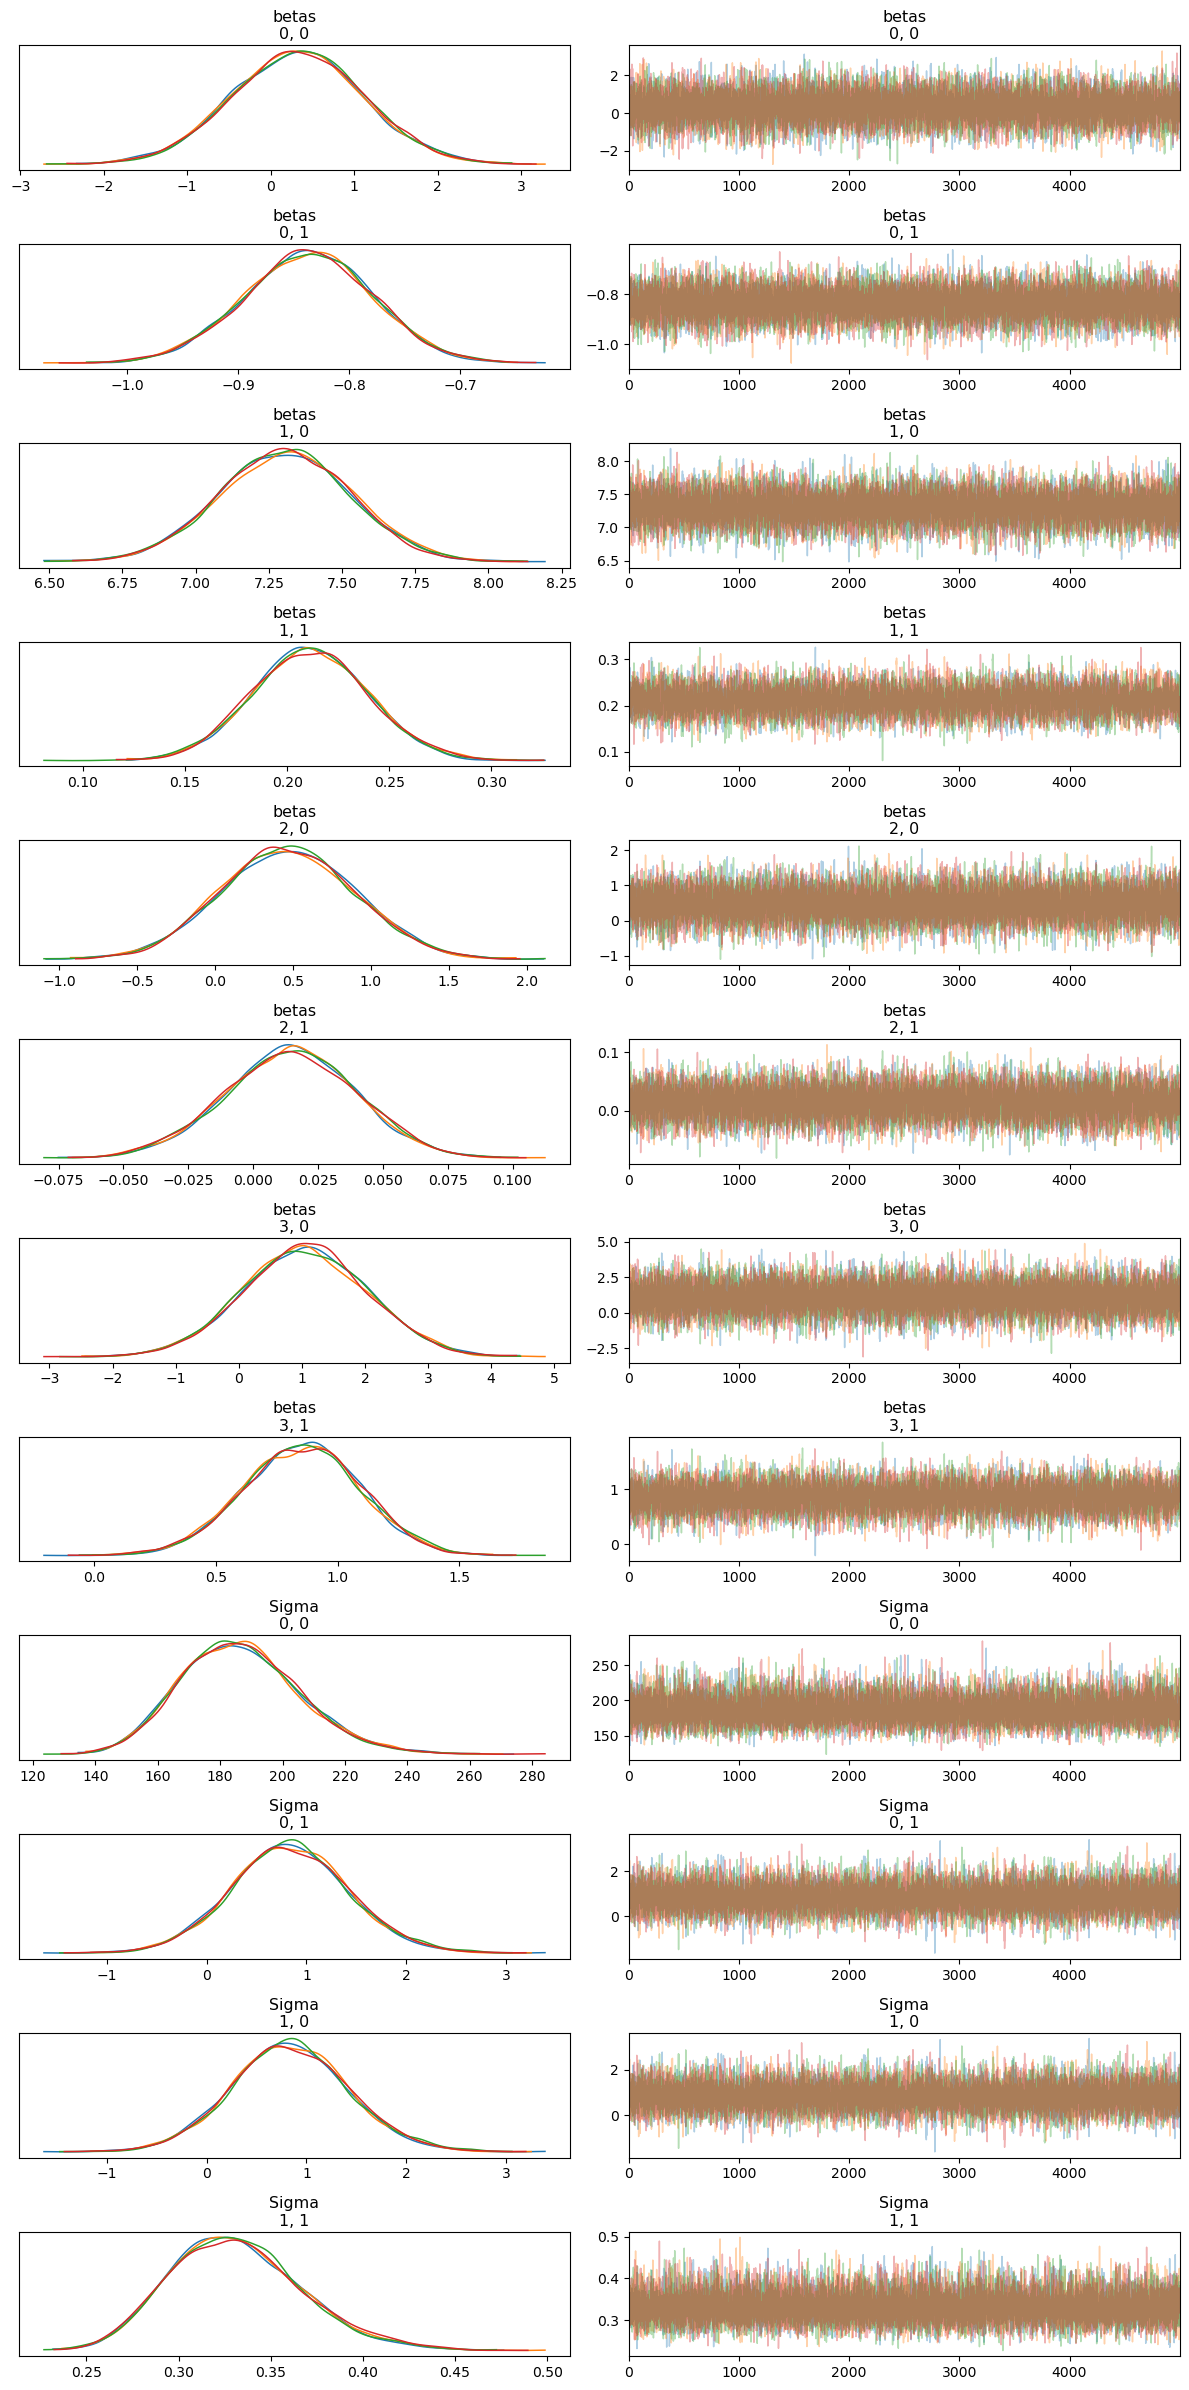

In [25]:
az.plot_trace(wine_sim, var_names=["betas", "Sigma"], compact = False)
plt.tight_layout()
plt.show()

As suggested by the summary table above, the right column of plots show no issues with chain convergence. The distributions of all parameters shown are unimodal, with most of them centered at 0.

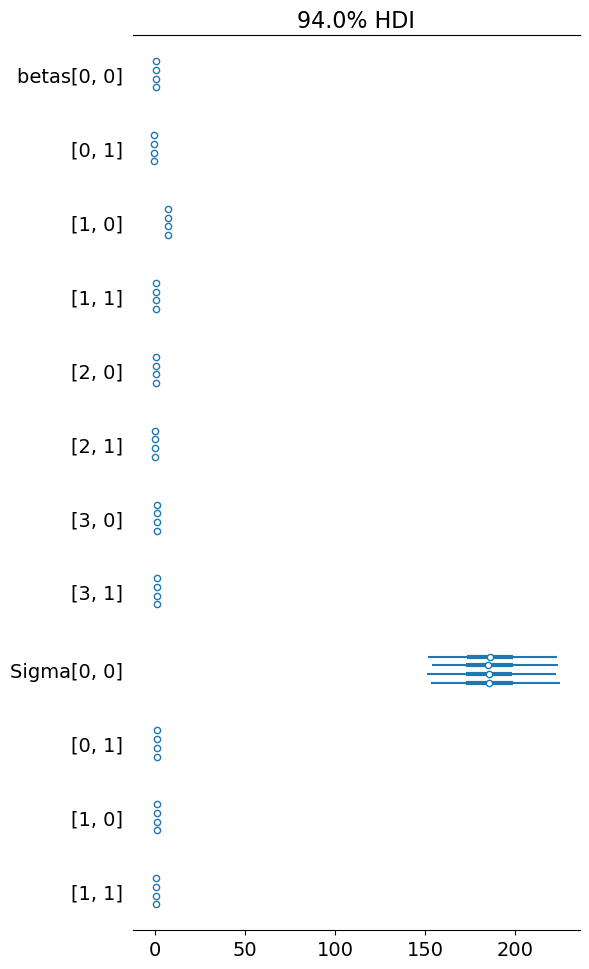

In [26]:
az.plot_forest(wine_sim, var_names=["betas", "Sigma"], combined = False)
plt.tight_layout()
plt.show()

The large scale of sigma$[0,0]$ makes it hard to see the HDI intervals of the other parameters.

/opt/conda/lib/python3.11/site-packages/arviz/plots/plot_utils.py:272: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (48) in plot_autocorr, generating only 40 plots
  warnings.warn(


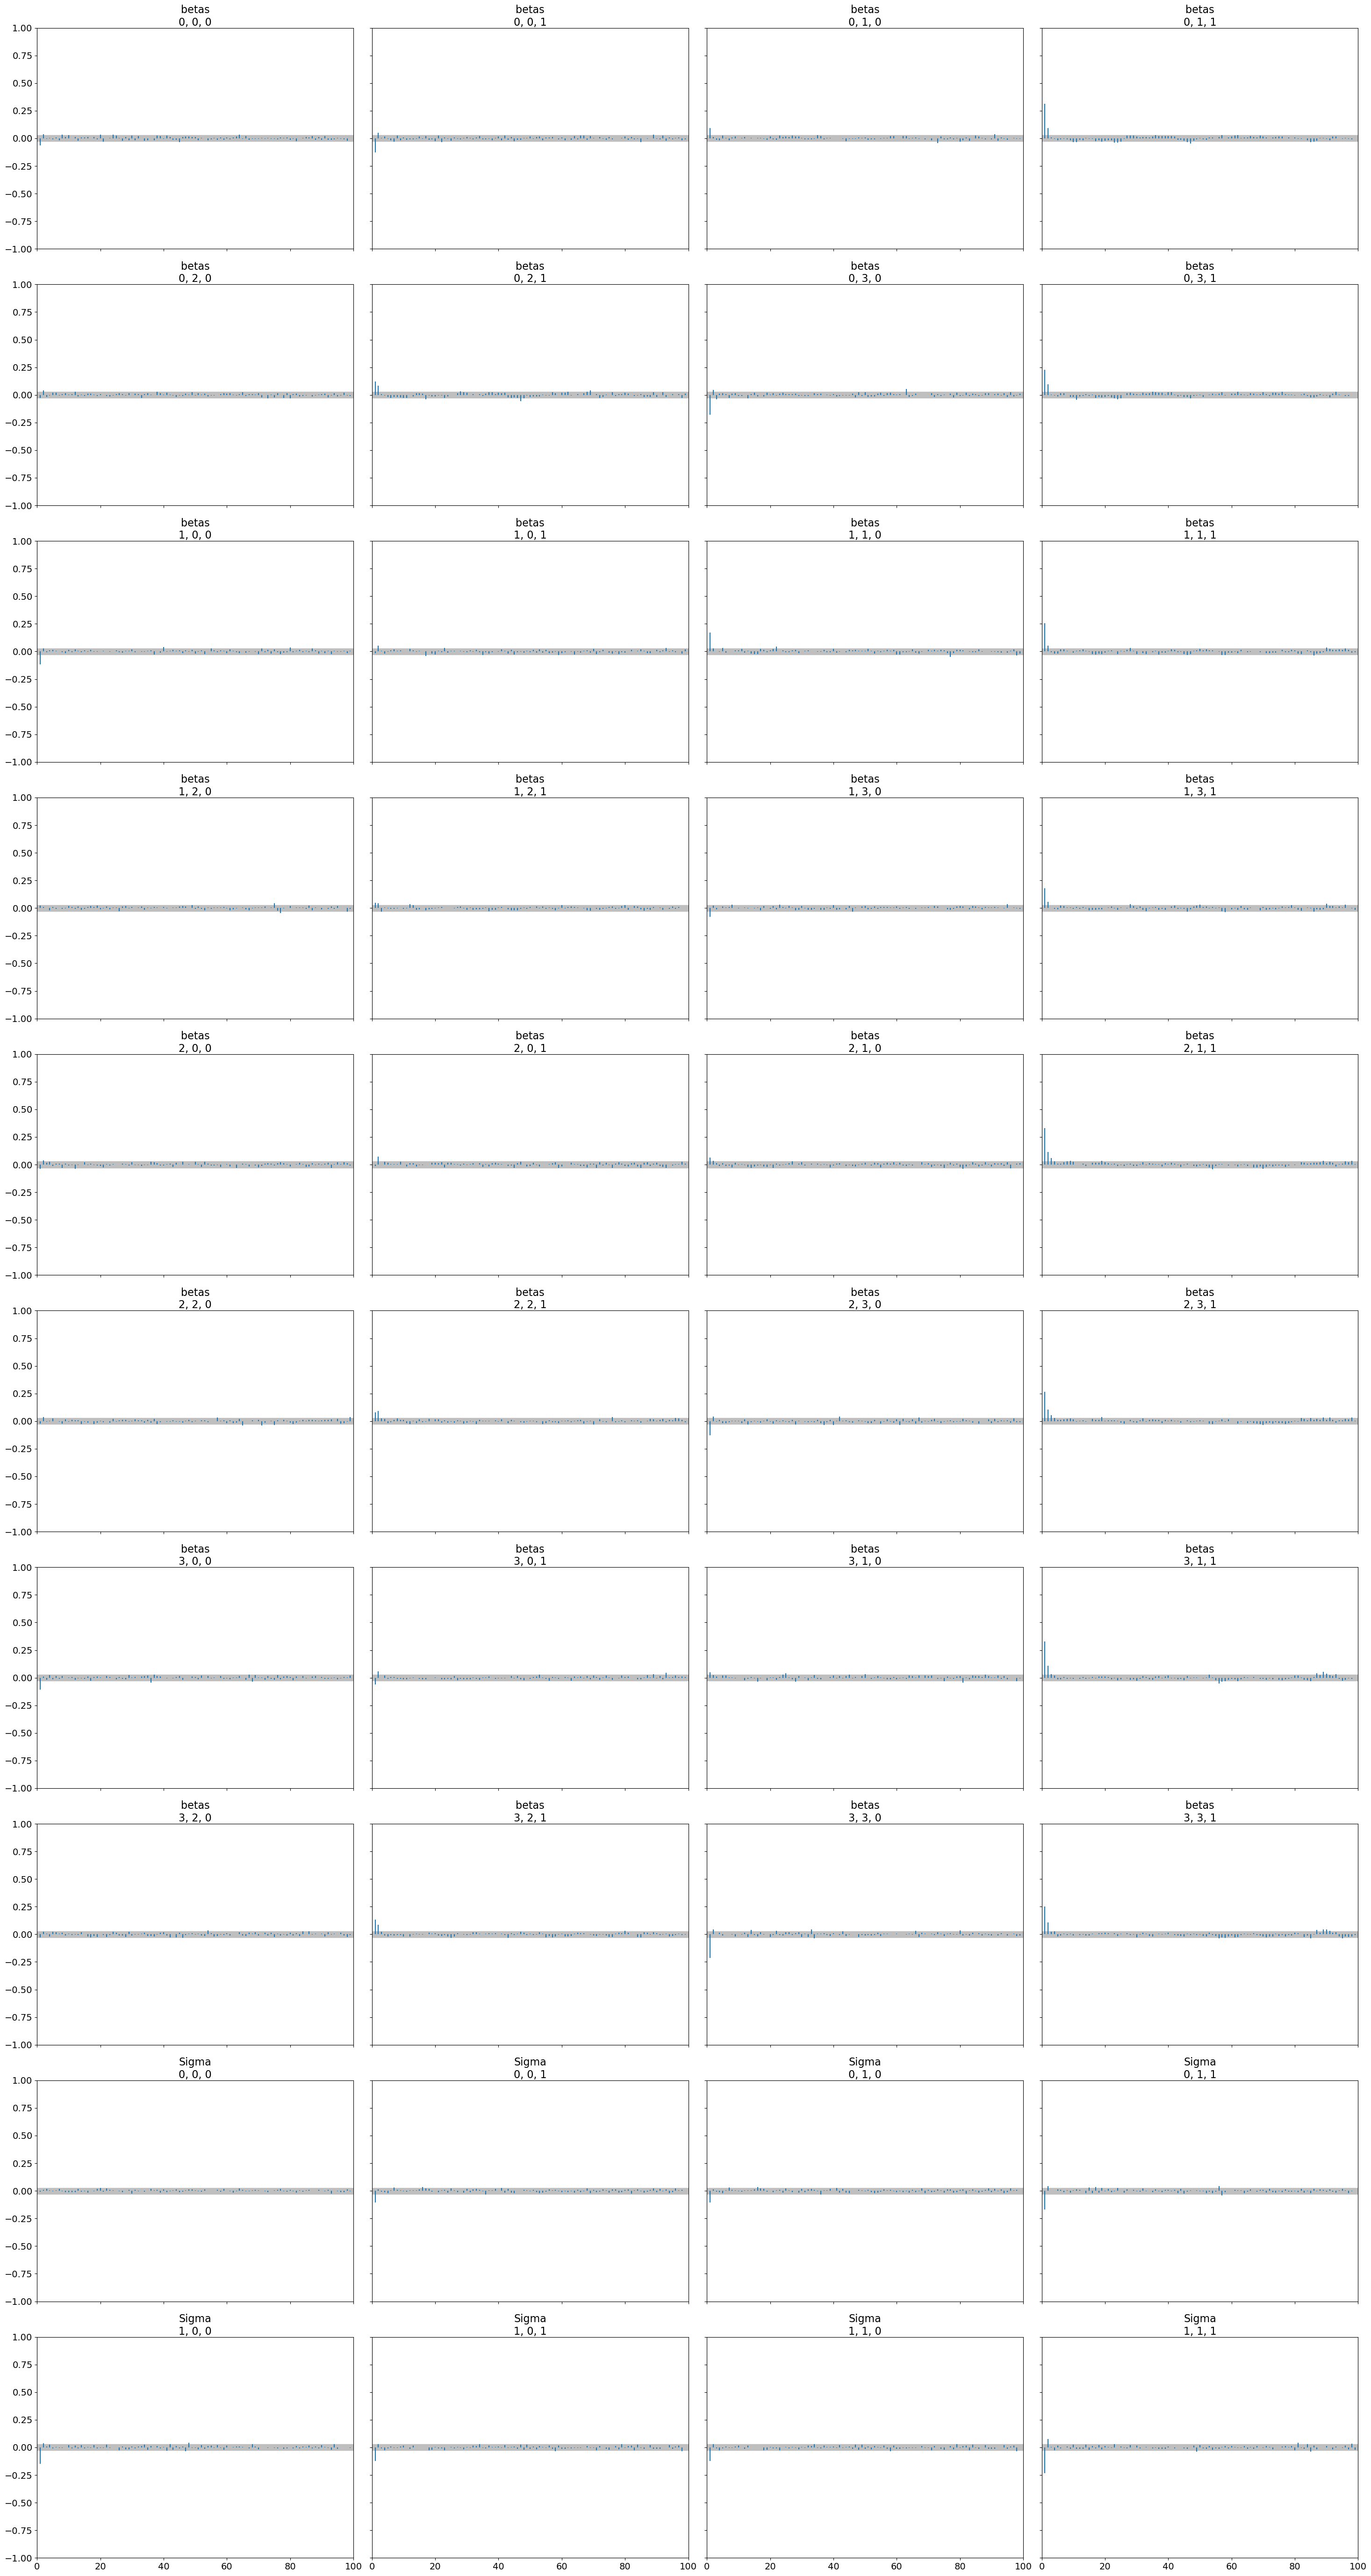

In [24]:
az.plot_autocorr(wine_sim, var_names=["betas", "Sigma"])
plt.tight_layout()
plt.show()

Autocorrelation shrinks to 0 very quickly, which indicates good mixing.

We now perform exploration of additional values of n (the work so far is for the entire dataset).

In [61]:
len(wine)
print(wine.head())
n_values = [30, 60, 100]

def get_subset(df, n):
    """Randomly sample n rows from df."""
    return df.sample(n=n, random_state=42)

feature_sets = {
    "p2": ["Alcohol", "Hue"],
    "p6": ["Alcohol", "Color intensity", "Hue", "class", "Ash"]
}

outcome_sets = {
    "m1": ["Magnesium"], 
    "m2": ["Magnesium", "Flavanoids"]
}

   class  Alcohol  Malic acid   Ash  Alcalinity of ash  Magnesium  \
0      1    14.23        1.71  2.43               15.6        127   
1      1    13.20        1.78  2.14               11.2        100   
2      1    13.16        2.36  2.67               18.6        101   
3      1    14.37        1.95  2.50               16.8        113   
4      1    13.24        2.59  2.87               21.0        118   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color intensity   Hue  OD280/OD315 of diluted wines  Proline   
0             5.64  1.04                          3.92      1065  
1             4.38  1.05

In [62]:
def fit_multivariate_regression(df, predictors, outcomes, draws=1000, tune=500):
    """
    Fits a Bayesian multivariate regression (MvNormal) model using 
    an LKJ prior for covariance if multiple outcomes.
    Returns the trace, model, and runtime in seconds.
    """
    # 1. Possibly create dummy vars for Class if needed
    #    If 'Class' in predictors, do get_dummies, etc.
    df_temp = df.copy()
    if "Class" in predictors:
        df_temp = pd.get_dummies(df_temp, columns=["Class"], prefix="Class", drop_first=True)
        # Replace "Class" in the predictor list with the new dummy columns
        predictor_list = []
        for col in predictors:
            if col == "Class":
                # add the new dummies except the dropped one
                predictor_list += [c for c in df_temp.columns if c.startswith("Class_")]
            else:
                predictor_list.append(col)
    else:
        predictor_list = predictors
    
    # Add an intercept
    df_temp["Intercept"] = 1.0
    predictor_list = ["Intercept"] + predictor_list
    
    # 2. Construct X, Y
    X = df_temp[predictor_list].values
    Y = df_temp[outcomes].values  # shape: (n, m)
    
    n, p = X.shape
    m = len(outcomes)

    # 3. Build & sample the model
    start_time = time.time()
    with pm.Model() as model:
        # If m=1, we can just do a normal; if m>1, do MvNormal with an LKJ prior
        betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m)) if m>1 else pm.Normal("betas", mu=0, sigma=1, shape=(p,))
        
        mu = pm.math.dot(X, betas)  # shape=(n,m) if m>1, or (n,) if m=1

        if m == 1:
            # univariate
            sigma = pm.Exponential("sigma", 1.0)
            Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y.ravel())
        else:
            # multivariate
            packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                         sd_dist=pm.Exponential.dist(1.0, shape=m),
                                         compute_corr=False)
            L = pm.expand_packed_triangular(m, packed_L)
            Sigma = pm.Deterministic("Sigma", L @ L.T)
            Y_obs = pm.MvNormal("Y_obs", mu=mu, chol=L, observed=Y)

        trace = pm.sample(
            draws=draws, 
            tune=tune, 
            chains=4, 
            target_accept=0.9, 
            random_seed=42
        )

    end_time = time.time()
    runtime = end_time - start_time

    return model, trace, runtime


In [63]:
results = []

for n_sub in n_values:
    df_sub = get_subset(wine, n_sub)

    for p_name, feats in feature_sets.items():
        for m_name, outs in outcome_sets.items():
            print(f"=== n={n_sub}, p={p_name} ({len(feats)} feats), m={m_name} ({len(outs)} outcomes) ===")
            model, trace, runtime = fit_multivariate_regression(
                df_sub, 
                predictors=feats, 
                outcomes=outs,
                draws=1000, 
                tune=500
            )
            summary = az.summary(trace, var_names=["betas", "Sigma"], round_to=2) if len(outs) > 1 else az.summary(trace, var_names=["betas", "sigma"], round_to=2)
            print(summary)
            print(f"Runtime (s): {runtime:.2f}\n")
            
            # Store results
            results.append({
                "n": n_sub,
                "p": len(feats),
                "m": len(outs),
                "runtime": runtime,
                "summary": summary
            })


=== n=30, p=p2 (2 feats), m=m1 (1 outcomes) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.


          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
betas[0]  0.50  1.01   -1.43     2.33       0.02     0.01   3460.57   2669.99   
betas[1]  7.25  0.18    6.91     7.57       0.00     0.00   3185.83   2918.91   
betas[2]  0.51  1.00   -1.34     2.36       0.02     0.01   3346.47   3049.85   
sigma     9.85  1.11    7.89    11.89       0.02     0.01   3544.32   2550.48   

          r_hat  
betas[0]    1.0  
betas[1]    1.0  
betas[2]    1.0  
sigma       1.0  
Runtime (s): 7.46

=== n=30, p=p2 (2 feats), m=m2 (2 outcomes) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 199 seconds.


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]    0.53   1.00   -1.33     2.41       0.02     0.01   3297.67   
betas[0, 1]   -0.71   0.95   -2.51     1.06       0.02     0.01   2309.62   
betas[1, 0]    7.24   0.18    6.92     7.59       0.00     0.00   2368.90   
betas[1, 1]    0.08   0.08   -0.06     0.22       0.00     0.00   2213.45   
betas[2, 0]    0.49   1.04   -1.35     2.47       0.02     0.01   3238.86   
betas[2, 1]    1.74   0.57    0.67     2.79       0.01     0.01   3149.85   
Sigma[0, 0]  100.24  23.62   60.95   146.20       0.44     0.32   3226.61   
Sigma[0, 1]    1.43   1.32   -1.02     3.95       0.02     0.02   3631.24   
Sigma[1, 0]    1.43   1.32   -1.02     3.95       0.02     0.02   3631.24   
Sigma[1, 1]    0.67   0.20    0.35     1.04       0.00     0.00   3069.92   

             ess_tail  r_hat  
betas[0, 0]   2657.00    1.0  
betas[0, 1]   2261.29    1.0  
betas[1, 0]   2437.74    1.0  
betas[1, 1]   2419.79    1.0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.


          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
betas[0]  0.46  1.02   -1.36     2.41       0.01     0.02   5365.18   2757.77   
betas[1]  6.35  0.36    5.69     7.01       0.01     0.00   3064.13   2663.29   
betas[2]  1.45  0.62    0.23     2.54       0.01     0.01   3988.75   2739.01   
betas[3]  0.56  1.02   -1.42     2.44       0.01     0.01   4894.78   2674.54   
betas[4]  0.29  0.88   -1.42     1.84       0.01     0.01   4666.97   2854.26   
betas[5]  1.63  0.98   -0.16     3.45       0.01     0.01   4315.64   2257.06   
sigma     9.76  1.14    7.77    11.93       0.02     0.01   4194.27   2803.61   

          r_hat  
betas[0]    1.0  
betas[1]    1.0  
betas[2]    1.0  
betas[3]    1.0  
betas[4]    1.0  
betas[5]    1.0  
sigma       1.0  
Runtime (s): 8.90

=== n=30, p=p6 (5 feats), m=m2 (2 outcomes) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 364 seconds.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]   0.50   1.00   -1.53     2.25       0.01     0.01   5722.22   
betas[0, 1]   0.47   0.94   -1.25     2.23       0.02     0.01   2755.67   
betas[1, 0]   6.34   0.36    5.65     6.97       0.01     0.01   2436.21   
betas[1, 1]   0.16   0.10   -0.03     0.35       0.00     0.00   2175.29   
betas[2, 0]   1.48   0.62    0.33     2.64       0.01     0.01   3337.80   
betas[2, 1]   0.02   0.06   -0.08     0.13       0.00     0.00   2584.39   
betas[3, 0]   0.52   0.97   -1.46     2.23       0.02     0.01   3957.98   
betas[3, 1]   0.96   0.52   -0.04     1.91       0.01     0.01   2581.68   
betas[4, 0]   0.29   0.91   -1.39     2.02       0.01     0.01   4418.44   
betas[4, 1]  -0.83   0.16   -1.12    -0.53       0.00     0.00   2722.24   
betas[5, 0]   1.61   0.99   -0.36     3.34       0.02     0.01   3540.78   
betas[5, 1]   0.00   0.42   -0.79     0.77       0.01     0.01   2166.72   
Sigma[0, 0] 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]   0.56  1.01   -1.28     2.48       0.02     0.02   3237.68   
betas[1]   7.30  0.15    7.01     7.56       0.00     0.00   2696.26   
betas[2]   0.60  0.99   -1.21     2.51       0.02     0.01   2939.26   
sigma     10.36  0.87    8.84    12.08       0.02     0.01   3249.66   

          ess_tail  r_hat  
betas[0]   2649.62    1.0  
betas[1]   2540.33    1.0  
betas[2]   2428.18    1.0  
sigma      2496.33    1.0  
Runtime (s): 9.63

=== n=60, p=p2 (2 feats), m=m2 (2 outcomes) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 276 seconds.


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]    0.58   0.97   -1.34     2.37       0.02     0.01   3431.49   
betas[0, 1]   -1.15   0.88   -2.68     0.58       0.02     0.01   2353.74   
betas[1, 0]    7.29   0.14    7.03     7.57       0.00     0.00   3373.56   
betas[1, 1]    0.09   0.07   -0.05     0.21       0.00     0.00   2427.65   
betas[2, 0]    0.61   0.99   -1.34     2.38       0.02     0.01   3732.24   
betas[2, 1]    2.11   0.41    1.32     2.88       0.01     0.01   3025.18   
Sigma[0, 0]  110.06  19.06   76.07   143.74       0.32     0.23   3878.11   
Sigma[0, 1]    0.68   1.00   -1.13     2.64       0.02     0.01   3407.45   
Sigma[1, 0]    0.68   1.00   -1.13     2.64       0.02     0.01   3407.45   
Sigma[1, 1]    0.60   0.12    0.40     0.83       0.00     0.00   2989.41   

             ess_tail  r_hat  
betas[0, 0]   2813.58    1.0  
betas[0, 1]   2248.04    1.0  
betas[1, 0]   2620.20    1.0  
betas[1, 1]   2536.31    1.0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]   0.54  1.00   -1.19     2.50       0.01     0.01   4990.52   
betas[1]   6.78  0.31    6.20     7.37       0.01     0.00   2503.90   
betas[2]   0.48  0.49   -0.41     1.43       0.01     0.01   3524.88   
betas[3]   0.67  0.99   -1.25     2.52       0.01     0.01   4836.73   
betas[4]   0.32  0.86   -1.25     1.92       0.01     0.01   5005.43   
betas[5]   1.58  0.98   -0.22     3.44       0.02     0.01   3774.74   
sigma     10.47  0.92    8.85    12.23       0.01     0.01   5493.04   

          ess_tail  r_hat  
betas[0]   2678.79    1.0  
betas[1]   2174.98    1.0  
betas[2]   2766.81    1.0  
betas[3]   2892.53    1.0  
betas[4]   2603.26    1.0  
betas[5]   2631.08    1.0  
sigma      2952.65    1.0  
Runtime (s): 9.97

=== n=60, p=p6 (5 feats), m=m2 (2 outcomes) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 456 seconds.


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]    0.56   0.99   -1.32     2.38       0.01     0.01   4452.23   
betas[0, 1]    1.26   0.94   -0.60     2.90       0.02     0.01   2490.98   
betas[1, 0]    6.77   0.32    6.20     7.39       0.01     0.00   2556.35   
betas[1, 1]    0.08   0.08   -0.07     0.24       0.00     0.00   2093.50   
betas[2, 0]    0.50   0.50   -0.38     1.48       0.01     0.01   3177.02   
betas[2, 1]    0.03   0.04   -0.04     0.10       0.00     0.00   2421.84   
betas[3, 0]    0.66   0.99   -1.25     2.46       0.01     0.01   4688.75   
betas[3, 1]    0.94   0.39    0.17     1.66       0.01     0.01   2837.63   
betas[4, 0]    0.32   0.85   -1.25     1.88       0.01     0.01   3597.58   
betas[4, 1]   -0.88   0.10   -1.08    -0.70       0.00     0.00   3064.41   
betas[5, 0]    1.56   0.95   -0.24     3.27       0.02     0.01   3732.13   
betas[5, 1]    0.16   0.24   -0.26     0.62       0.00     0.00   3252.18   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]   0.68  1.01   -1.06     2.68       0.02     0.01   3690.99   
betas[1]   7.45  0.15    7.16     7.73       0.00     0.00   2982.76   
betas[2]   0.90  0.98   -0.91     2.71       0.02     0.01   3309.46   
sigma     14.03  0.93   12.37    15.77       0.02     0.01   3820.15   

          ess_tail  r_hat  
betas[0]   2946.60    1.0  
betas[1]   2592.40    1.0  
betas[2]   2446.96    1.0  
sigma      2578.43    1.0  
Runtime (s): 7.96

=== n=100, p=p2 (2 feats), m=m2 (2 outcomes) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 298 seconds.


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]    0.65   1.01   -1.17     2.57       0.02     0.01   3543.41   
betas[0, 1]   -1.54   0.82   -3.08    -0.02       0.02     0.01   2629.16   
betas[1, 0]    7.45   0.15    7.15     7.71       0.00     0.00   2992.20   
betas[1, 1]    0.13   0.06    0.02     0.25       0.00     0.00   2613.98   
betas[2, 0]    0.95   0.98   -0.81     2.81       0.02     0.01   3455.82   
betas[2, 1]    1.93   0.34    1.27     2.54       0.01     0.00   3737.77   
Sigma[0, 0]  199.97  26.71  148.68   246.89       0.43     0.31   3972.81   
Sigma[0, 1]    0.05   1.10   -1.94     2.18       0.02     0.02   3700.06   
Sigma[1, 0]    0.05   1.10   -1.94     2.18       0.02     0.02   3700.06   
Sigma[1, 1]    0.64   0.10    0.47     0.82       0.00     0.00   3904.01   

             ess_tail  r_hat  
betas[0, 0]   2308.77    1.0  
betas[0, 1]   2516.18    1.0  
betas[1, 0]   2423.37    1.0  
betas[1, 1]   2540.26    1.0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.


           mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]   0.64  0.96   -1.09     2.50       0.01     0.01   5137.92   
betas[1]   7.05  0.32    6.47     7.66       0.01     0.00   2855.19   
betas[2]   0.13  0.57   -0.89     1.22       0.01     0.01   3675.29   
betas[3]   0.90  0.98   -0.90     2.78       0.01     0.01   5605.64   
betas[4]   0.41  0.87   -1.15     2.08       0.01     0.01   5917.02   
betas[5]   1.68  0.97   -0.19     3.44       0.01     0.01   4600.04   
sigma     14.09  0.95   12.37    15.90       0.01     0.01   4759.60   

          ess_tail  r_hat  
betas[0]   2902.45    1.0  
betas[1]   2652.55    1.0  
betas[2]   2772.93    1.0  
betas[3]   3097.20    1.0  
betas[4]   2721.41    1.0  
betas[5]   2915.51    1.0  
sigma      2731.61    1.0  
Runtime (s): 9.89

=== n=100, p=p6 (5 feats), m=m2 (2 outcomes) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 515 seconds.


               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]    0.63   0.98   -1.15     2.51       0.01     0.01   4684.37   
betas[0, 1]    2.22   0.85    0.73     3.85       0.02     0.01   2380.08   
betas[1, 0]    7.05   0.31    6.47     7.62       0.01     0.00   2774.46   
betas[1, 1]    0.06   0.07   -0.06     0.20       0.00     0.00   2432.99   
betas[2, 0]    0.10   0.55   -0.93     1.11       0.01     0.01   3479.71   
betas[2, 1]    0.01   0.03   -0.05     0.07       0.00     0.00   3199.75   
betas[3, 0]    0.90   0.97   -0.96     2.67       0.02     0.01   3980.88   
betas[3, 1]    0.46   0.30   -0.10     1.00       0.01     0.00   3341.43   
betas[4, 0]    0.40   0.88   -1.29     2.04       0.01     0.01   3979.20   
betas[4, 1]   -0.96   0.08   -1.11    -0.80       0.00     0.00   2752.08   
betas[5, 0]    1.70   0.98   -0.16     3.50       0.02     0.01   3816.71   
betas[5, 1]    0.13   0.18   -0.22     0.48       0.00     0.00   3917.21   

In [64]:
results_df = pd.DataFrame([{"n": r["n"], "p": r["p"], "m": r["m"], "runtime": r["runtime"]} for r in results])
print("Summary of Runtimes:")
print(results_df)

Summary of Runtimes:
      n  p  m     runtime
0    30  2  1    7.464694
1    30  2  2  208.080400
2    30  5  1    8.898697
3    30  5  2  374.787442
4    60  2  1    9.630082
5    60  2  2  290.147874
6    60  5  1    9.971618
7    60  5  2  465.866749
8   100  2  1    7.956371
9   100  2  2  311.052102
10  100  5  1    9.887114
11  100  5  2  524.166181


It's clear that predicting two continuous outcomes comes at a huge computational cost. Multivariate procedures are expected to take longer because they're more complicated, but the big difference observed here is unexpected.

In [67]:
betas_comparison = []

for res in results:
    summary_df = res["summary"]
    # Filter the summary for rows where the parameter name starts with "betas"
    betas_summary = summary_df[summary_df.index.str.startswith("betas")]
    for param in betas_summary.index:
        betas_comparison.append({
            "n": res["n"],
            "p": res["p"],
            "m": res["m"],
            "parameter": param,
            "mean": betas_summary.loc[param, "mean"]
        })

# Convert the collected information into a DataFrame.
betas_df = pd.DataFrame(betas_comparison)
print(betas_df)

      n  p  m    parameter  mean
0    30  2  1     betas[0]  0.50
1    30  2  1     betas[1]  7.25
2    30  2  1     betas[2]  0.51
3    30  2  2  betas[0, 0]  0.53
4    30  2  2  betas[0, 1] -0.71
..  ... .. ..          ...   ...
76  100  5  2  betas[3, 1]  0.46
77  100  5  2  betas[4, 0]  0.40
78  100  5  2  betas[4, 1] -0.96
79  100  5  2  betas[5, 0]  1.70
80  100  5  2  betas[5, 1]  0.13

[81 rows x 5 columns]


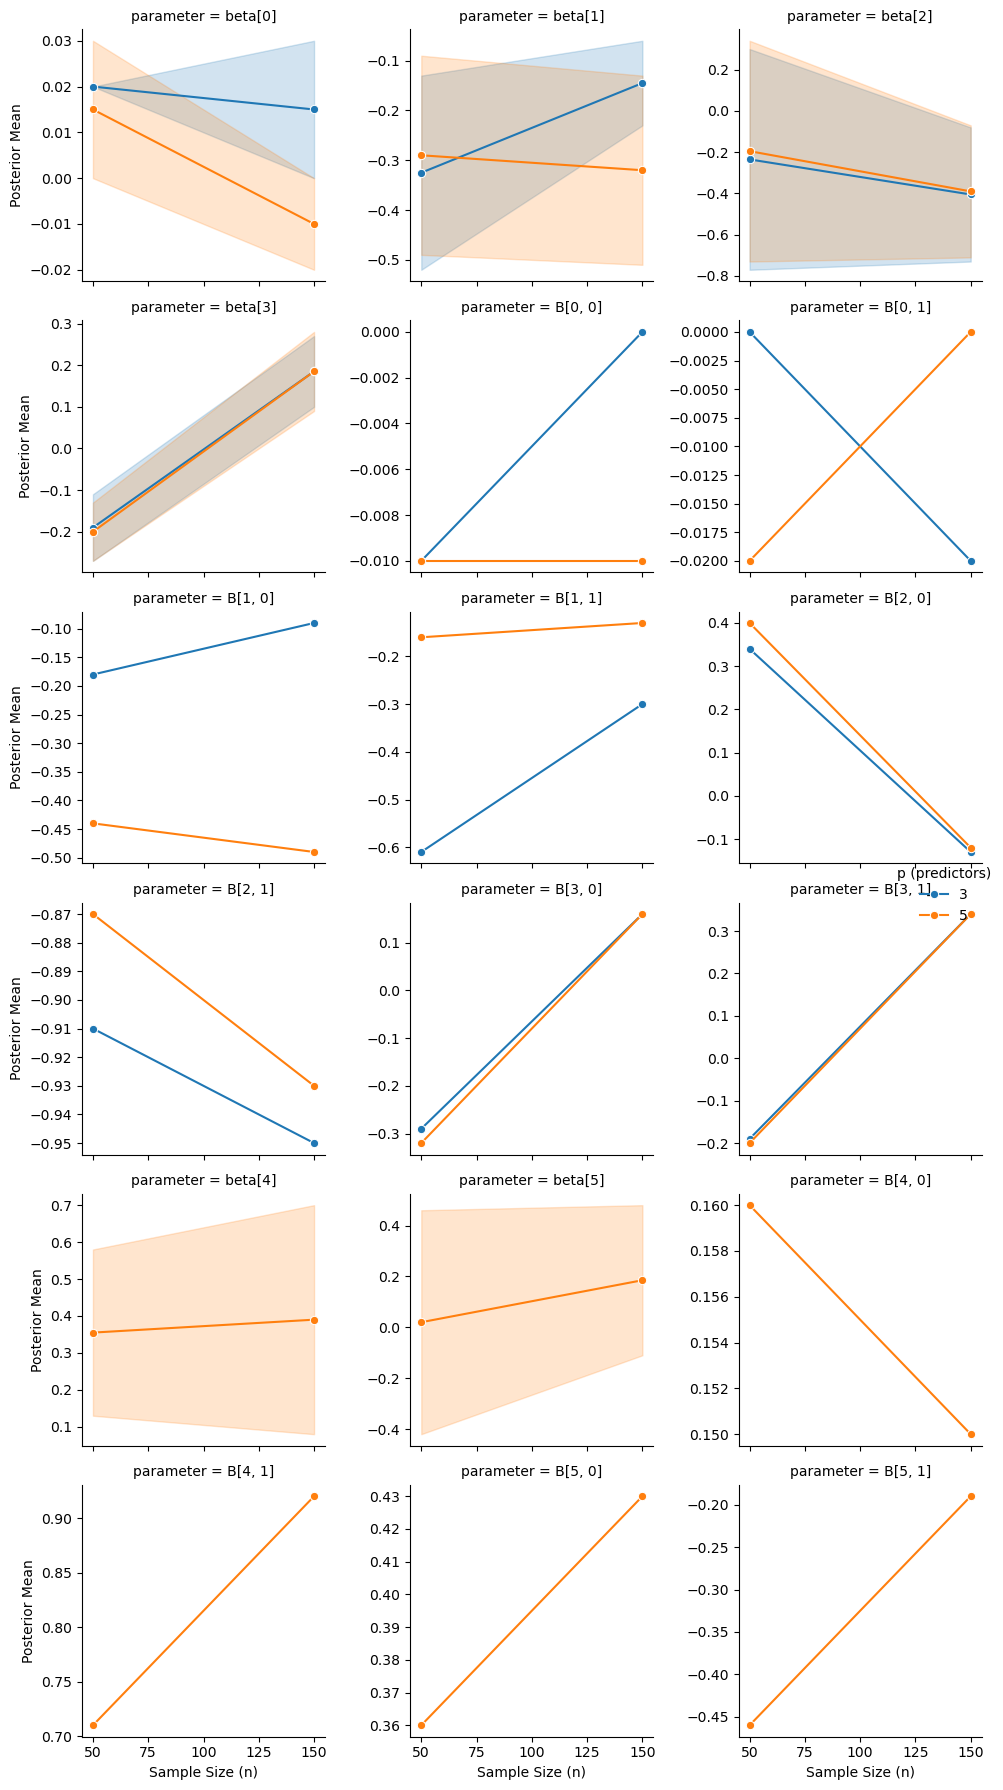

In [19]:
# Filter the DataFrame to include parameters that start with "B" (for m=2)
# or "beta" (for m=1). Adjust this filter if your parameter names differ.
plot_df = loan_betas_df[loan_betas_df["parameter"].str.contains("B|beta")].copy()

# Create a FacetGrid: one subplot per regression coefficient.
g = sns.FacetGrid(
    data=plot_df,
    col="parameter",    # Each subplot is a unique coefficient.
    hue="p",            # Color by the number of predictors.
    sharey=False,       # Allow each subplot its own y-axis range.
    col_wrap=3          # Wrap subplots into rows of 3.
)

# Map a line plot of posterior mean versus sample size (n) onto the grid.
g.map(sns.lineplot, "n", "mean", marker="o")

# Add legend and labels.
g.add_legend(title="p (predictors)")
g.set_axis_labels("Sample Size (n)", "Posterior Mean")
plt.tight_layout()
plt.show()

We see a lot of changes relative to sample size and number of predictors, which indicates that these aspects of model-building are vital to one's results.

# Question 3
---

In [2]:
loan_data = pd.read_csv("loan_data.csv")
print(loan_data.head())

loan_data["gender_binary"] = (loan_data["person_gender"] == "male").astype(int)


n_values = [30, 60, 100]

def get_subset(df, n):
    """Randomly sample n rows from df."""
    return df.sample(n=n, random_state=42)

feature_sets = {
    "p3": ["person_age", "person_income", "loan_amnt"],  
    "p5": ["person_age", "person_income", "loan_amnt", "loan_int_rate", "person_emp_exp"]
}

outcome_sets = {
    "m1_loan": ["loan_status"],          
    "m1_gender": ["gender_binary"],        
    "m2_both": ["gender_binary", "loan_status"] 
}


   person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                         3.0           561  

In [12]:
def fit_multivariate_classification(df, predictors, outcomes, draws=500, tune=300):
    """
    Fits a Bayesian classification model.
    
    - If len(outcomes) == 1, uses standard logistic regression.
    - If len(outcomes) == 2, uses a latent variable approach with noncentered parameterization.
    
    This updated version standardizes the predictors and sets:
      - target_accept = 0.98,
      - max_treedepth = 15,
      - init = "jitter+adapt_diag".
      
    Returns (model, trace, runtime).
    """
    # Work on a copy and add an intercept.
    df_temp = df.copy()
    df_temp["Intercept"] = 1.0
    pred_list = ["Intercept"] + predictors

    # Construct design matrices.
    X = df_temp[pred_list].values
    Y = df_temp[outcomes].values  # shape: (n, m)
    n, p_dim = X.shape
    m_dim = len(outcomes)

    # Standardize predictors for better sampling performance.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    start_time = time.time()
    with pm.Model() as model:
        if m_dim == 1:
            # Single-outcome logistic regression.
            beta = pm.Normal("beta", mu=0, sigma=1, shape=p_dim)
            mu = pm.math.dot(X_scaled, beta)
            pm.Bernoulli("Y_obs", logit_p=mu, observed=Y.ravel())
        else:
            # Two-outcome logistic regression with latent covariance using noncentered parameterization.
            B = pm.Normal("B", mu=0, sigma=1, shape=(p_dim, m_dim))
            mu = pm.math.dot(X_scaled, B)  # shape: (n, m_dim)
            
            # Define the Cholesky factor via an LKJ prior.
            packed_L = pm.LKJCholeskyCov(
                "packed_L",
                n=m_dim,
                eta=2.0,
                sd_dist=pm.Exponential.dist(1.0, shape=m_dim),
                compute_corr=False
            )
            L = pm.expand_packed_triangular(m_dim, packed_L)
            Sigma = pm.Deterministic("Sigma", L @ L.T)
            
            # Noncentered parameterization:
            # Sample z_raw ~ N(0, I) and define Z = mu + dot(z_raw, L.T)
            z_raw = pm.Normal("z_raw", mu=0, sigma=1, shape=(n, m_dim))
            Z = pm.Deterministic("Z", mu + pm.math.dot(z_raw, L.T))
            
            # Bernoulli likelihood for each outcome dimension.
            pm.Bernoulli("Y0", logit_p=Z[:, 0], observed=Y[:, 0])
            pm.Bernoulli("Y1", logit_p=Z[:, 1], observed=Y[:, 1])

        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=4,       # Use a single chain to reduce memory usage.
            target_accept=0.98,
            init="jitter+adapt_diag",
            random_seed=83
        )
    end_time = time.time()
    runtime = end_time - start_time

    return model, trace, runtime


In [13]:
n_values = [50, 150]  

results = []

for n_val in n_values:
    df_sub = get_subset(loan_data, n_val)
    
    for p_name, feats in feature_sets.items():
        for m_name, outs in outcome_sets.items():
            print(f"=== n={n_val}, p={p_name} (len={len(feats)}), m={m_name} (len={len(outs)}) ===")
            model, trace, runtime = fit_multivariate_classification(
                df_sub,
                predictors = feats,
                outcomes = outs,
                draws = 1000,
                tune = 500
            )
            # Summaries:
            if len(outs) == 1:
                sum_df = az.summary(trace, var_names=["beta"], round_to=2)
            else:
                sum_df = az.summary(trace, var_names=["B", "Sigma"], round_to=2)
            print(sum_df)
            print(f"Runtime: {runtime:.2f} seconds\n")
            
            # Store
            results.append({
                "n": n_val,
                "p": len(feats),
                "m": len(outs),
                "runtime": runtime,
                "summary": sum_df
            })


=== n=50, p=p3 (len=3), m=m1_loan (len=1) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0]  0.02  0.98   -1.84     1.86       0.02     0.01   2630.51   2638.95   
beta[1] -0.52  0.30   -1.07     0.04       0.01     0.00   3081.28   2742.23   
beta[2] -0.77  0.39   -1.51    -0.07       0.01     0.01   2804.87   2040.77   
beta[3] -0.11  0.36   -0.78     0.55       0.01     0.01   2705.62   2794.22   

         r_hat  
beta[0]    1.0  
beta[1]    1.0  
beta[2]    1.0  
beta[3]    1.0  
Runtime: 4.73 seconds

=== n=50, p=p3 (len=3), m=m1_gender (len=1) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0]  0.02  0.99   -1.93     1.79       0.02     0.02   3069.48   2183.63   
beta[1] -0.13  0.29   -0.70     0.39       0.00     0.00   3404.30   2695.17   
beta[2]  0.30  0.35   -0.38     0.92       0.01     0.01   2421.16   2631.36   
beta[3] -0.27  0.33   -0.84     0.38       0.01     0.01   2424.95   2621.60   

         r_hat  
beta[0]    1.0  
beta[1]    1.0  
beta[2]    1.0  
beta[3]    1.0  
Runtime: 4.67 seconds

=== n=50, p=p3 (len=3), m=m2_both (len=2) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B, packed_L, z_raw]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 65 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
B[0, 0]     -0.01   0.96   -1.92     1.70       0.01     0.02   5864.76   
B[0, 1]      0.00   1.02   -1.89     1.88       0.01     0.02   6055.62   
B[1, 0]     -0.18   0.45   -1.06     0.64       0.01     0.01   2363.86   
B[1, 1]     -0.61   0.42   -1.44     0.11       0.01     0.01   2898.84   
B[2, 0]      0.34   0.50   -0.56     1.35       0.01     0.01   2807.99   
B[2, 1]     -0.91   0.50   -1.87     0.02       0.01     0.01   2417.04   
B[3, 0]     -0.29   0.48   -1.25     0.60       0.01     0.01   2633.94   
B[3, 1]     -0.19   0.48   -1.09     0.71       0.01     0.01   2677.33   
Sigma[0, 0]  6.32  10.58    0.00    22.46       0.38     0.27    380.58   
Sigma[0, 1]  0.84   1.64   -0.95     4.07       0.06     0.04    828.49   
Sigma[1, 0]  0.84   1.64   -0.95     4.07       0.06     0.04    828.49   
Sigma[1, 1]  2.85   5.28    0.00    10.64       0.18     0.12    630.75   

             ess_tail  r

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.


         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0]  0.03  0.96   -1.70     1.88       0.02     0.01   3978.12   2751.17   
beta[1] -0.09  0.56   -1.12     0.99       0.01     0.01   2495.85   2986.73   
beta[2] -0.73  0.41   -1.52     0.00       0.01     0.01   3612.84   2830.43   
beta[3] -0.13  0.38   -0.83     0.59       0.01     0.01   3774.69   2720.40   
beta[4]  0.58  0.33   -0.04     1.21       0.01     0.00   3376.59   2359.80   
beta[5] -0.42  0.57   -1.56     0.61       0.01     0.01   2454.86   2844.81   

         r_hat  
beta[0]    1.0  
beta[1]    1.0  
beta[2]    1.0  
beta[3]    1.0  
beta[4]    1.0  
beta[5]    1.0  
Runtime: 5.87 seconds

=== n=50, p=p5 (len=5), m=m1_gender (len=1) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.


         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0] -0.00  0.99   -1.91     1.81       0.02     0.02   3828.59   3170.95   
beta[1] -0.49  0.57   -1.61     0.53       0.01     0.01   2310.66   2622.67   
beta[2]  0.34  0.36   -0.32     1.02       0.01     0.01   2987.77   2653.16   
beta[3] -0.27  0.34   -0.90     0.35       0.01     0.00   3210.71   3098.41   
beta[4]  0.13  0.31   -0.44     0.74       0.01     0.00   3408.80   2427.58   
beta[5]  0.46  0.57   -0.63     1.51       0.01     0.01   2222.96   2185.69   

         r_hat  
beta[0]    1.0  
beta[1]    1.0  
beta[2]    1.0  
beta[3]    1.0  
beta[4]    1.0  
beta[5]    1.0  
Runtime: 5.89 seconds

=== n=50, p=p5 (len=5), m=m2_both (len=2) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B, packed_L, z_raw]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 36 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
B[0, 0]     -0.01   1.00   -1.90     1.83       0.01     0.02   6178.34   
B[0, 1]     -0.02   1.00   -1.86     1.89       0.01     0.02   4815.98   
B[1, 0]     -0.44   0.67   -1.73     0.79       0.01     0.01   2776.09   
B[1, 1]     -0.16   0.64   -1.38     1.07       0.01     0.01   3054.67   
B[2, 0]      0.40   0.51   -0.51     1.41       0.01     0.01   2265.70   
B[2, 1]     -0.87   0.52   -1.84     0.07       0.01     0.01   3075.42   
B[3, 0]     -0.32   0.50   -1.22     0.67       0.01     0.01   2647.73   
B[3, 1]     -0.20   0.49   -1.13     0.70       0.01     0.01   2978.91   
B[4, 0]      0.16   0.45   -0.72     1.02       0.01     0.01   2382.52   
B[4, 1]      0.71   0.45   -0.11     1.58       0.01     0.01   2854.07   
B[5, 0]      0.36   0.68   -0.99     1.57       0.01     0.01   2807.12   
B[5, 1]     -0.46   0.65   -1.62     0.77       0.01     0.01   2933.33   
Sigma[0, 0]  7.23  10.60 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0]  0.03  0.97   -1.75     1.91       0.02     0.02   2827.63   2790.52   
beta[1] -0.23  0.17   -0.57     0.09       0.00     0.00   3262.51   2424.05   
beta[2] -0.73  0.23   -1.17    -0.31       0.00     0.00   2716.07   2505.06   
beta[3]  0.27  0.20   -0.10     0.64       0.00     0.00   2587.03   2685.96   

         r_hat  
beta[0]    1.0  
beta[1]    1.0  
beta[2]    1.0  
beta[3]    1.0  
Runtime: 4.74 seconds

=== n=150, p=p3 (len=3), m=m1_gender (len=1) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0] -0.00  0.99   -1.86     1.83       0.02     0.02   2688.76   2578.70   
beta[1] -0.06  0.17   -0.39     0.24       0.00     0.00   3310.83   2670.57   
beta[2] -0.08  0.18   -0.43     0.26       0.00     0.00   2855.51   2678.55   
beta[3]  0.10  0.18   -0.23     0.45       0.00     0.00   2469.16   2744.10   

         r_hat  
beta[0]    1.0  
beta[1]    1.0  
beta[2]    1.0  
beta[3]    1.0  
Runtime: 4.78 seconds

=== n=150, p=p3 (len=3), m=m2_both (len=2) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B, packed_L, z_raw]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 71 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
B[0, 0]      0.00   0.99   -1.87     1.86       0.01     0.02   7342.83   
B[0, 1]     -0.02   1.01   -2.08     1.70       0.01     0.02   7258.85   
B[1, 0]     -0.09   0.32   -0.70     0.49       0.01     0.01   2573.15   
B[1, 1]     -0.30   0.25   -0.81     0.13       0.01     0.01   2033.58   
B[2, 0]     -0.13   0.33   -0.79     0.48       0.01     0.01   2783.78   
B[2, 1]     -0.95   0.37   -1.68    -0.31       0.01     0.01    912.16   
B[3, 0]      0.16   0.35   -0.46     0.87       0.01     0.01   2187.28   
B[3, 1]      0.34   0.28   -0.15     0.87       0.01     0.00   2911.24   
Sigma[0, 0]  8.76  11.99    0.00    30.53       0.74     0.52    133.81   
Sigma[0, 1]  1.00   1.33   -0.44     3.76       0.06     0.04    493.31   
Sigma[1, 0]  1.00   1.33   -0.44     3.76       0.06     0.04    493.31   
Sigma[1, 1]  2.97   4.52    0.00    10.30       0.23     0.16    303.98   

             ess_tail  r

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.


         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0] -0.02  0.99   -1.82     1.81       0.02     0.02   3449.26   2732.10   
beta[1] -0.13  0.44   -0.96     0.68       0.01     0.01   2073.14   2435.19   
beta[2] -0.71  0.23   -1.10    -0.27       0.00     0.00   2788.35   2733.39   
beta[3]  0.28  0.21   -0.10     0.68       0.00     0.00   3029.81   2263.33   
beta[4]  0.70  0.19    0.36     1.10       0.00     0.00   3031.15   2635.20   
beta[5] -0.11  0.44   -0.91     0.73       0.01     0.01   2028.29   2286.98   

         r_hat  
beta[0]    1.0  
beta[1]    1.0  
beta[2]    1.0  
beta[3]    1.0  
beta[4]    1.0  
beta[5]    1.0  
Runtime: 6.83 seconds

=== n=150, p=p5 (len=5), m=m1_gender (len=1) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.


         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0]  0.00  0.96   -1.76     1.85       0.02     0.02   3841.41   2480.90   
beta[1] -0.51  0.43   -1.33     0.28       0.01     0.01   2101.58   2205.52   
beta[2] -0.07  0.18   -0.42     0.26       0.00     0.00   3117.69   2695.62   
beta[3]  0.09  0.18   -0.25     0.44       0.00     0.00   3134.40   2619.25   
beta[4]  0.08  0.17   -0.24     0.38       0.00     0.00   3463.50   2302.99   
beta[5]  0.48  0.43   -0.33     1.27       0.01     0.01   1991.49   2225.13   

         r_hat  
beta[0]    1.0  
beta[1]    1.0  
beta[2]    1.0  
beta[3]    1.0  
beta[4]    1.0  
beta[5]    1.0  
Runtime: 6.73 seconds

=== n=150, p=p5 (len=5), m=m2_both (len=2) ===


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B, packed_L, z_raw]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 43 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
B[0, 0]      -0.01   1.00   -1.87     1.88       0.01     0.02   6873.92   
B[0, 1]      -0.00   1.02   -1.98     1.85       0.01     0.02   5281.48   
B[1, 0]      -0.49   0.62   -1.61     0.67       0.01     0.01   2008.81   
B[1, 1]      -0.13   0.52   -1.07     0.89       0.01     0.01   1971.98   
B[2, 0]      -0.12   0.40   -0.88     0.70       0.01     0.01   1394.49   
B[2, 1]      -0.93   0.38   -1.68    -0.30       0.02     0.01    666.03   
B[3, 0]       0.16   0.39   -0.56     0.97       0.01     0.01   1762.07   
B[3, 1]       0.34   0.28   -0.19     0.89       0.01     0.00   3165.61   
B[4, 0]       0.15   0.37   -0.53     0.87       0.01     0.01   1868.55   
B[4, 1]       0.92   0.35    0.34     1.63       0.01     0.01    580.32   
B[5, 0]       0.43   0.62   -0.70     1.68       0.02     0.01   1331.33   
B[5, 1]      -0.19   0.53   -1.16     0.83       0.01     0.01   1892.95   
Sigma[0, 0] 

 Based on the output of the simulation, there were a few divergences when $m = 2$, but otherwise the sampling goes well without much trouble.

In [15]:
results_df = pd.DataFrame([{
    "n": r["n"],
    "p": r["p"],
    "m": r["m"],
    "runtime": r["runtime"]
} for r in results])
results_df

,n,p,m,runtime
0,50,3,1,4.732306
1,50,3,1,4.667097
2,50,3,2,73.102643
3,50,5,1,5.874747
4,50,5,1,5.886236
5,50,5,2,44.100307
6,150,3,1,4.743832
7,150,3,1,4.776552
8,150,3,2,79.142637
9,150,5,1,6.825119


This table shows that predicting two binary outcomes comes at a huge computational cost. Multivariate procedures are expected to take longer because they're more complicated.

In [20]:
loan_betas_comparison = []

for res in results:
    summary_df = res["summary"]
    # Determine the prefix based on the number of outcomes
    param_prefix = "beta" if res["m"] == 1 else "B"
    betas_summary = summary_df[summary_df.index.str.startswith(param_prefix)]
    for param in betas_summary.index:
        loan_betas_comparison.append({
            "n": res["n"],
            "p": res["p"],
            "m": res["m"],
            "parameter": param,
            "mean": betas_summary.loc[param, "mean"]
        })

loan_betas_df = pd.DataFrame(loan_betas_comparison)
print(loan_betas_df)


      n  p  m parameter  mean
0    50  3  1   beta[0]  0.02
1    50  3  1   beta[1] -0.52
2    50  3  1   beta[2] -0.77
3    50  3  1   beta[3] -0.11
4    50  3  1   beta[0]  0.02
..  ... .. ..       ...   ...
75  150  5  2   B[3, 1]  0.34
76  150  5  2   B[4, 0]  0.15
77  150  5  2   B[4, 1]  0.92
78  150  5  2   B[5, 0]  0.43
79  150  5  2   B[5, 1] -0.19

[80 rows x 5 columns]


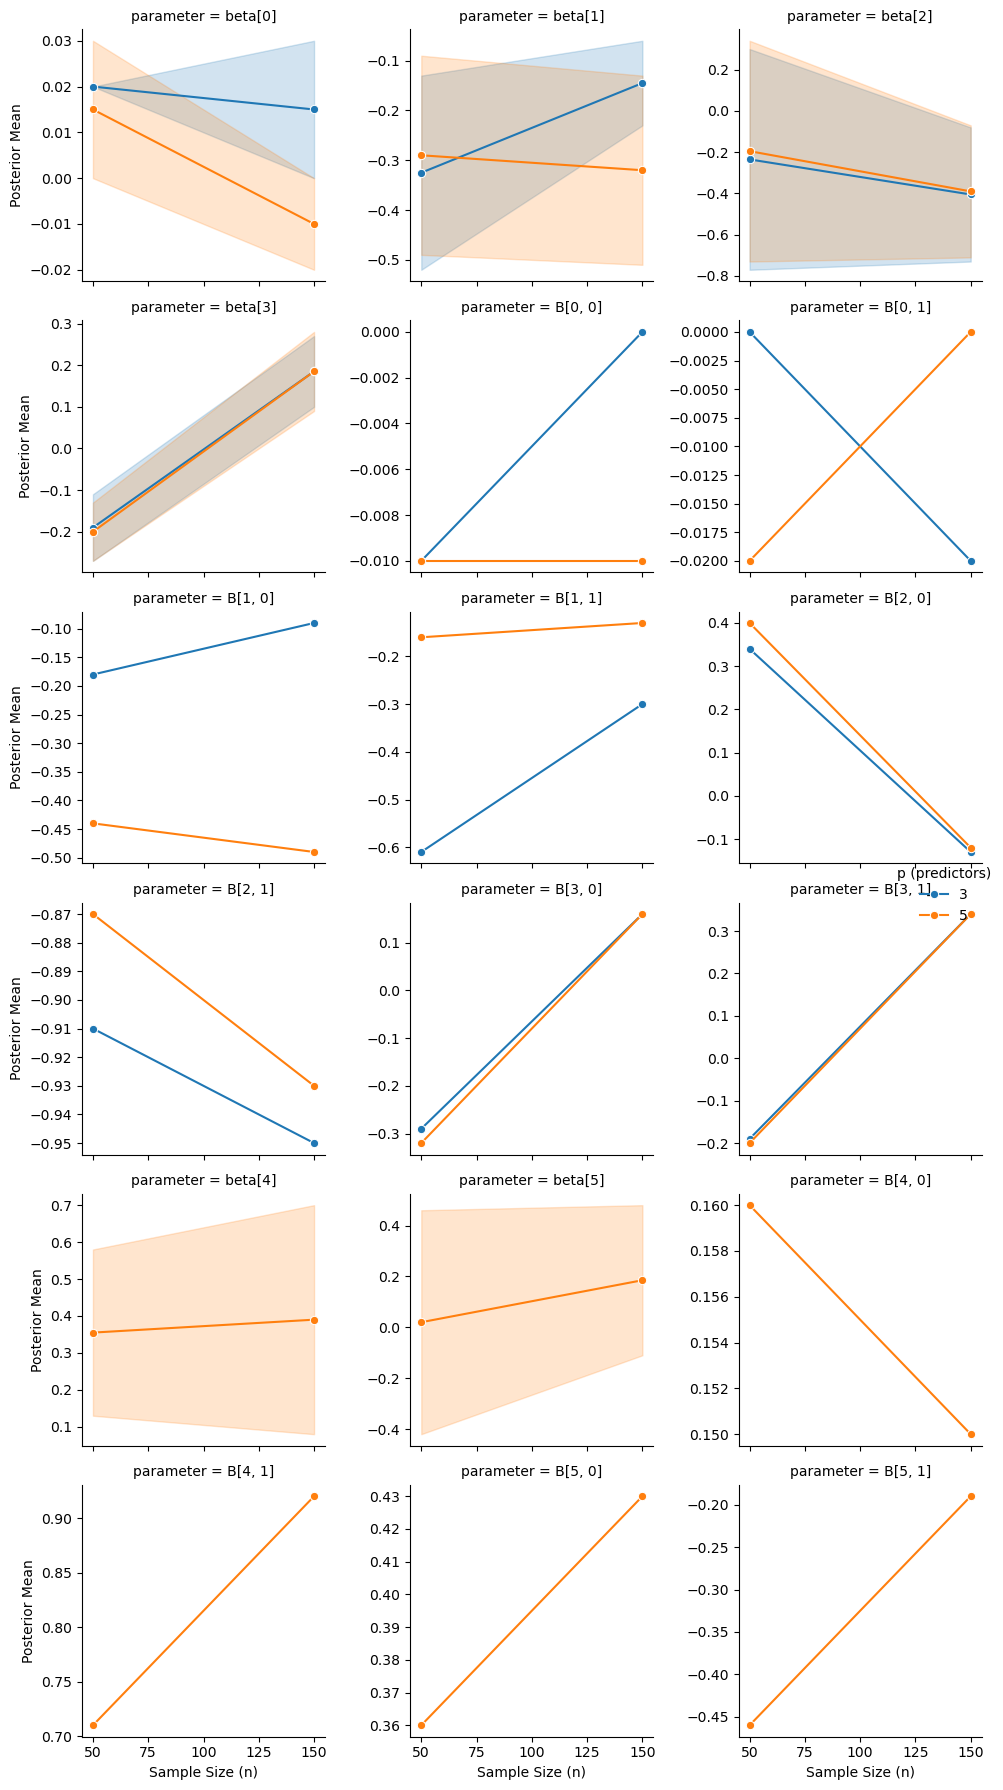

In [21]:
# Filter the DataFrame to include parameters that start with "B" (for m=2)
# or "beta" (for m=1). Adjust this filter if your parameter names differ.
plot_df = loan_betas_df[loan_betas_df["parameter"].str.contains("B|beta")].copy()

# Create a FacetGrid: one subplot per regression coefficient.
g = sns.FacetGrid(
    data=plot_df,
    col="parameter",    # Each subplot is a unique coefficient.
    hue="p",            # Color by the number of predictors.
    sharey=False,       # Allow each subplot its own y-axis range.
    col_wrap=3          # Wrap subplots into rows of 3.
)

# Map a line plot of posterior mean versus sample size (n) onto the grid.
g.map(sns.lineplot, "n", "mean", marker="o")

# Add legend and labels.
g.add_legend(title="p (predictors)")
g.set_axis_labels("Sample Size (n)", "Posterior Mean")
plt.tight_layout()
plt.show()

We see a lot of changes relative to sample size and number of predictors, which indicates that these aspects of model-building are vital to one's results.